Tengo un dataset de contiene `pesos`, `alturas` y `géneros`. Puedo, a partir de estos datos construir un clasificador que me permita, dado un par de valores `peso, altura` de una persona, estimar su `género`?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [15]:
df = pd.read_csv('alturas-pesos-1-train.csv')
df.head()

,Genero,Peso,Altura
0,Mujer,61,162
1,Hombre,97,181
2,Hombre,73,172
3,Mujer,55,157
4,Mujer,56,151


In [16]:
df.describe()

,Peso,Altura
count,8000.000000,8000.000000
mean,72.301125,167.616125
std,14.628908,9.836608
min,31.000000,138.000000
25%,61.000000,160.000000
50%,72.000000,167.000000
75%,84.000000,175.000000
max,121.000000,199.000000


In [17]:
df[['Peso','Altura']].cov()

,Peso,Altura
Peso,214.004949,132.878329
Altura,132.878329,96.758860


In [18]:
df[['Peso','Altura']].corr()

,Peso,Altura
Peso,1.000000,0.923415
Altura,0.923415,1.000000


## ¿Estimo usando las probabilidades marginales o la conjunta?

En este tipo de problemas tengo dos opciones, y una relación de compromiso entre ambos enfoques:

1. Tratar a pesos y alturas como variables independientes: Estimo la distribución de las variables por separado.
2. Considerar la probabilidad conjunta entre ambas variables, peso y altura.

La **relación de compromiso** entre estos enfoques, está en el grado de precisión debido a la cantidad de datos que  tendré si considero a las variables como independientes (trabajo con las probabilidades marginales) o no (trabajo con las probabilidades conjuntas).
Si considero a la altura independiente del peso, (Ej: Altura de 160 cm, sin considerar los pesos), voy a tener muchos más datos para calcular la probabilidad, y por ende mi estimación de dicha probabilidad será mejor, más precisa. No obstante, estaré ignorando la clara relación que tienen las dos variables. Si en cambio trabajo con las probabilidades conjuntas, el problema que surge es que no voy a tener tantos datos para cada par de valores, por ende mi cálculo de la probabilidad no será tan preciso.


## Estimación con Probabilidades Marginales

Voy a considerar que Peso y Altura son variables independientes entre sí. Los pasos a seguir para construir mi estimador serán:

1. Evaluar las distribuciones de probabilidad de peso y altura para hombres y mujeres respectivamente
2. Dado un par de valores `peso` y `altura`, calcular las probabilidades en base a la distribución anterior
3. Calcular las probabilidades de que sea hombre y de que sea mujer, dados el peso y la altura: $P(Hombre|peso,altura)$ y $P(Mujer|peso,altura)$. Para esto aplico Bayes
4. Comparar ambos valores y clasificar en Hombre o Mujer según qué valor sea mayor
5. Evaluar la performance de mi clasificador con eel test set.

1. Distribuciones de probabilidad y peso

In [19]:
from collections import Counter

In [20]:
pesos_h = df[df['Genero'] == 'Hombre']['Peso']
frec_pesos_h = dict(Counter(pesos_h))
alturas_h = df[df['Genero'] == 'Hombre']['Altura']
frec_alturas_h = dict(Counter(alturas_h))

pesos_m = df[df['Genero'] == 'Mujer']['Peso']
alturas_m = df[df['Genero'] == 'Mujer']['Altura']
frec_pesos_m = dict(Counter(pesos_m))
frec_alturas_m = dict(Counter(alturas_m))

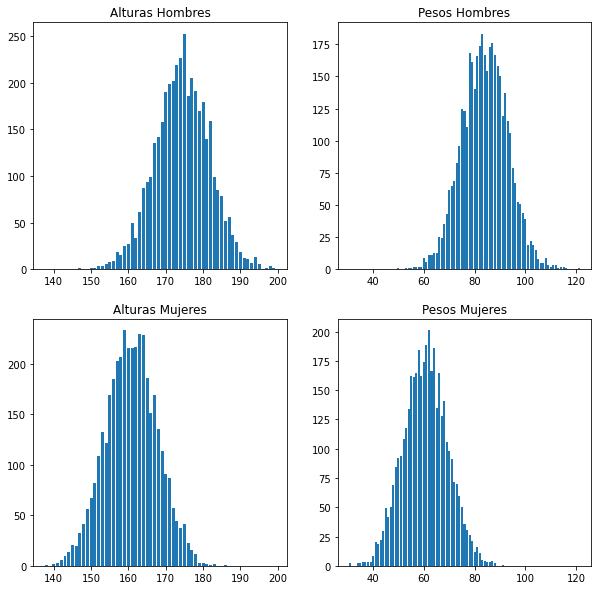

In [21]:
# Seteo grilla de 2x2 y sus dimensiones
fig, axs = plt.subplots(2,2, figsize =(10,10))                    
ax = axs[0,0]
ax.bar(frec_alturas_h.keys(), frec_alturas_h.values())
ax.set_title('Alturas Hombres')

ax = axs[0,1]
ax.bar(frec_pesos_h.keys(), frec_pesos_h.values())
ax.set_title('Pesos Hombres')

ax = axs[1,0]
ax.bar(frec_alturas_m.keys(), frec_alturas_m.values())
ax.set_title('Alturas Mujeres')

ax = axs[1,1]
ax.bar(frec_pesos_m.keys(), frec_pesos_m.values())
ax.set_title('Pesos Mujeres')

# Este método me permite compartir ejes. Lo hago así para ver las etiquetas de ejes en todos los subplots
axs[1,0].sharex(axs[0,0])
axs[1,1].sharex(axs[0,1])

plt.show()

Estimo las probabilidades como distribuciones normales tomando los parámetros media y desviación estándar de la muestra

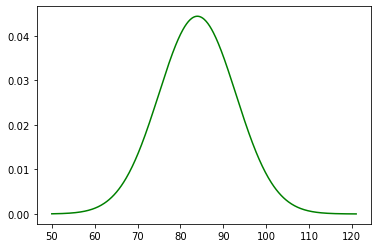

In [22]:
from scipy.stats import norm
# Pesos Hombres
x = np.linspace(pesos_h.min(), pesos_h.max(), 500)
y = norm.pdf(x,pesos_h.mean(), pesos_h.std())
plt.plot(x,y, color = 'g')

In [23]:
prob_pesos_h = {k: v/len(pesos_h) for k,v in frec_pesos_h.items()}
prob_alturas_h = {k: v/len(alturas_h) for k,v in frec_alturas_h.items()}
prob_pesos_m = {k: v/len(pesos_m) for k,v in frec_pesos_m.items()}
prob_alturas_m = {k: v/len(alturas_m) for k,v in frec_alturas_m.items()}

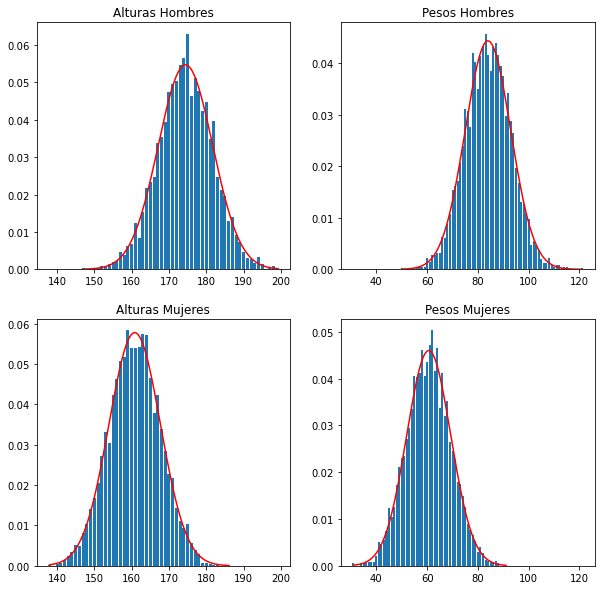

In [26]:
# Seteo grilla de 2x2 y sus dimensiones
fig, axs = plt.subplots(2,2, figsize =(10,10))                    
ax = axs[0,0]
x = np.linspace(alturas_h.min(), alturas_h.max(), 500)
y = norm.pdf(x,alturas_h.mean(), alturas_h.std())
ax.plot(x,y, color = 'r')
ax.bar(prob_alturas_h.keys(), prob_alturas_h.values())
ax.set_title('Alturas Hombres')

ax = axs[0,1]
ax.bar(prob_pesos_h.keys(), prob_pesos_h.values())
x = np.linspace(pesos_h.min(), pesos_h.max(), 500)
y = norm.pdf(x,pesos_h.mean(), pesos_h.std())
ax.plot(x,y, color = 'r')
ax.set_title('Pesos Hombres')

ax = axs[1,0]
ax.bar(prob_alturas_m.keys(), prob_alturas_m.values())
x = np.linspace(alturas_m.min(), alturas_m.max(), 500)
y = norm.pdf(x,alturas_m.mean(), alturas_m.std())
ax.plot(x,y, color = 'r')
ax.set_title('Alturas Mujeres')

ax = axs[1,1]
ax.bar(prob_pesos_m.keys(), prob_pesos_m.values())
x = np.linspace(pesos_m.min(), pesos_m.max(), 500)
y = norm.pdf(x,pesos_m.mean(), pesos_m.std())
ax.plot(x,y, color = 'r')
ax.set_title('Pesos Mujeres')

# Este método me permite compartir ejes. Lo hago así para ver las etiquetas de ejes en todos los subplots
axs[1,0].sharex(axs[0,0])
axs[1,1].sharex(axs[0,1])

plt.show()